In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import time
from datetime import timedelta
import pandas as pd
from collections import OrderedDict
from itertools import cycle
from transformers import AutoTokenizer
from sentencepiece import SentencePieceProcessor
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device_cap = torch.cuda.get_device_capability()
device_type = "cuda" if "cuda" in device else "cpu"
torch.cuda.set_device(device)
torch.manual_seed(8855)
print(torch.__version__)
print(device, device_cap)

2.1.0+cu121
cuda:0 (8, 6)


### Llama 2 from Scratch

In [2]:
# Using Huggingface
tokenizer = AutoTokenizer.from_pretrained("./llama2/")
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
# tokenizer.pad_token = tokenizer.eos_token #Optional

vocab = tokenizer.vocab

In [3]:
def encode(example):
    return tokenizer.encode(example, return_tensors="pt")


def decode(example):
    return tokenizer.batch_decode(
        example,
        skip_special_tokens=False,
        clean_up_tokenization_spaces=True,
    )[0]


print(f"Vocab Size: {len(vocab)}")
decode(
    encode(
        "hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"
    )
)

Vocab Size: 32001


'<s> hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions'

In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "hidden_dim": 768,
    "epochs": 1000,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}
GLOBAL_KEEP_TRACK = []

In [5]:
# Local Data only
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/TinyStoriesv1andv2-train.txt"],
        "val": ["../../data/TinyStoriesv1andv2-valid.txt"],
    },
    streaming=True,
)

# Stream Data
# dataset = load_dataset('IMJONEZZ/CombinedTinyStories') # optional: streaming=True but to_iterable is faster
# dataset = dataset.to_iterable_dataset()

# Minimal preprocessing
clean_dataset = dataset.filter(lambda example: len(example["text"]) > 2)

In [6]:
prompt = "Write a short story. Possible Story: "
tokenized_prompt = tokenizer(prompt, return_tensors="pt").input_ids

encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        [prompt + x for x in examples["text"]],
        padding=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())
train_data = cycle(train_data)
val_data = cycle(val_data)

test = next(train_data)
print(f"Actual text: {test['text']}")
print(f"Input Ids: {tokenizer.decode(test['input_ids'])}")
print(f"Length of text: {len(test['input_ids'])}")
print(test)

Actual text: The flame answered, "Yes, I can permit you to fly away but first you must promise to take care of your family." 
Input Ids: <s> Write a short story. Possible Story: The flame answered, "Yes, I can permit you to fly away but first you must promise to take care of your family." <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
Length of text: 169
{'text': 'The flame answered,

### Needed functions

In [7]:
# @torch.compile #For non-Windows users
def get_batches(
    data,
    batch_size,
    context_window,
    config=MASTER_CONFIG,
    debug=False,
):
    x = []
    y = []
    for _ in range(
        batch_size
    ):  # Adjust this lower if you're running out of memory
        batch_data = next(data)

        # pick random starting points
        ix = torch.randint(
            0, len(batch_data["input_ids"]) - context_window - 1, (2,)
        )
        batch_x = torch.stack(
            [batch_data["input_ids"][i : i + context_window] for i in ix]
        ).long()
        batch_y = torch.stack(
            [
                batch_data["input_ids"][i + 1 : i + context_window + 1]
                for i in ix
            ]
        ).long()
        x.append(batch_x)
        y.append(batch_y)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    return x, y


def get_lora_batches(
    data,
    batch_size,
    context_window=32,
):
    x = []
    y = []
    for _ in range(batch_size // 2):
        x_data = next(data)
        y_data = next(data)

        x_data = torch.stack([x_data["input_ids"]]).long()
        y_data = torch.stack([y_data["input_ids"]]).long()

        x.append(x_data)
        y.append(y_data)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    return x, y

In [8]:
@torch.no_grad()
def get_loss(model, lora=False, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for name, split in zip(["train", "val"], [train_data, val_data]):
        losses = []
        for _ in range(10):
            if lora == True:
                xb, yb = get_lora_batches(
                    split, config["batch_size"], config["context_window"]
                )
            else:
                xb, yb = get_batches(
                    split,
                    config["batch_size"],
                    config["context_window"],
                )
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[name] = np.mean(losses)
    model.train()
    return out


@torch.inference_mode()
def generate(
    model,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=None,
    max_new_tokens=30,
    lora=False,
):
    idx_list = [tokenized_prompt] * 5
    idx = torch.cat((idx_list), 0).long().to(device)
    if lora:
        idx = (
            torch.ones(5, 1).long().to(device)
        )  # Alternative without prompt
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config["context_window"] :])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits

        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(
                last_time_step_logits,
                min(top_k, last_time_step_logits.size(-1)),
            )
            last_time_step_logits[
                last_time_step_logits < v[:, [-1]]
            ] = -float("Inf")
        p = F.softmax(
            last_time_step_logits, dim=-1
        )  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Gross neural network that doesn't work

In [9]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
# opt_model = torch.compile(model) #Again, non-Windows folks should be compiling functions and models
# xs, ys = get_batches(
#     train_data,
#     MASTER_CONFIG["batch_size"],
#     MASTER_CONFIG["context_window"],
# )

# logits, loss = model(xs, ys)

model params: 18547809


### Training Loop

In [10]:
def train(
    model,
    optimizer,
    scheduler=None,
    data=None,
    config=MASTER_CONFIG,
    lora=False,
    print_logs=False,
):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        try:
            optimizer.zero_grad()

            if lora:
                xs, ys = get_lora_batches(data, config["batch_size"])
            else:
                xs, ys = get_batches(
                    data, config["batch_size"], config["context_window"]
                )

            logits, loss = model(xs, targets=ys)
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            if epoch % config["log_interval"] == 0:
                batch_time = time.time() - start_time
                x = get_loss(model, lora=lora)
                losses += [x]
                if print_logs:
                    print(
                        f"Epoch {epoch} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA: {timedelta(seconds=(batch_time * (config['epochs'] - epoch)/config['log_interval']))}"
                    )
                start_time = time.time()

                if scheduler:
                    print("lr: ", scheduler.get_last_lr())
        except StopIteration:
            print(f"Reached end of dataset on step {epoch}")
            break

    GLOBAL_KEEP_TRACK.append(
        f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']:.3f} | Val: {losses[-1]['val']:.3f}"
    )
    print(
        f"training loss {losses[-1]['train']:.3f} | validation loss: {losses[-1]['val']:.3f}"
    )
    return pd.DataFrame(losses).plot()

Epoch 0 | train loss 10.365 | val loss 10.341 | Time 0.122 | ETA: 0:00:02.431240
Epoch 50 | train loss 6.039 | val loss 5.986 | Time 0.351 | ETA: 0:00:06.667511
Epoch 100 | train loss 5.429 | val loss 5.553 | Time 0.345 | ETA: 0:00:06.215240
Epoch 150 | train loss 4.893 | val loss 5.294 | Time 0.347 | ETA: 0:00:05.891390
Epoch 200 | train loss 4.930 | val loss 4.945 | Time 0.346 | ETA: 0:00:05.541813
Epoch 250 | train loss 4.570 | val loss 4.817 | Time 0.346 | ETA: 0:00:05.187771
Epoch 300 | train loss 4.534 | val loss 4.706 | Time 0.413 | ETA: 0:00:05.787058
Epoch 350 | train loss 4.715 | val loss 4.562 | Time 0.408 | ETA: 0:00:05.297581
Epoch 400 | train loss 4.579 | val loss 4.428 | Time 0.403 | ETA: 0:00:04.834986
Epoch 450 | train loss 4.479 | val loss 4.357 | Time 0.406 | ETA: 0:00:04.462545
Epoch 500 | train loss 4.639 | val loss 4.398 | Time 0.399 | ETA: 0:00:03.991182
Epoch 550 | train loss 4.251 | val loss 4.354 | Time 0.401 | ETA: 0:00:03.605621
Epoch 600 | train loss 4.242 

<Axes: >

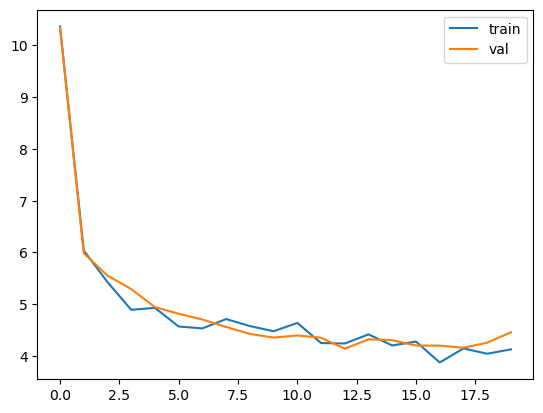

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, data=train_data, print_logs=True)

In [12]:
generate(model, config=MASTER_CONFIG)

['<s> Write a short story. Possible Story: 3 together thisar andze Lily said exciteded and smiled. Everything because he wasning loved to the time, he did not find like to',
 '<s> Write a short story. Possible Story: 3 years old and the castle her to safety. Lily was happy down. Today for a big and that he agreed and ever. The conhe her',
 '<s> Write a short story. Possible Story:  We should play in a walk onie took a big smile on the cuping that he was a sound a lot and still I will herself to slide',
 '<s> Write a short story. Possible Story: icy into the way home in a fun kind of was opened the perfect c jealous it and followed the old and d idea. They take a terrible',
 '<s> Write a short story. Possible Story: icy, you on the pas one day, it."  She ran back on it, you like warm appeared -?". Possible Story: Once upon']

In [13]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 4.129 | Val: 4.458


### RMS Normalization

This is as opposed to the original Batch Normalization used in the original transformers paper.
Basically it works by taking 1/sqrt(N) * frobenius_norm

In [14]:
class RMSNormalization(nn.Module):
    def __init__(self, layer_shape, eps=1e-5, bias=False):
        super(RMSNormalization, self).__init__()
        self.eps = eps
        self.register_parameter(
            "scale", nn.Parameter(torch.ones(layer_shape))
        )

    def forward(self, x):
        """
        assumes shape (batch, seq_len, d_model)
        """
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[: x.shape[1], :].unsqueeze(0) * raw

model params: 18630753
Epoch 0 | train loss 10.313 | val loss 10.333 | Time 0.022 | ETA: 0:00:00.438595
Epoch 50 | train loss 5.753 | val loss 5.861 | Time 0.419 | ETA: 0:00:07.956187
Epoch 100 | train loss 5.089 | val loss 5.057 | Time 0.418 | ETA: 0:00:07.523141
Epoch 150 | train loss 5.159 | val loss 5.224 | Time 0.431 | ETA: 0:00:07.325581
Epoch 200 | train loss 4.939 | val loss 4.566 | Time 0.410 | ETA: 0:00:06.558800
Epoch 250 | train loss 4.676 | val loss 4.890 | Time 0.411 | ETA: 0:00:06.168412
Epoch 300 | train loss 4.746 | val loss 4.487 | Time 0.359 | ETA: 0:00:05.025996
Epoch 350 | train loss 4.613 | val loss 4.649 | Time 0.360 | ETA: 0:00:04.679999
Epoch 400 | train loss 4.432 | val loss 4.629 | Time 0.359 | ETA: 0:00:04.308008
Epoch 450 | train loss 4.579 | val loss 4.253 | Time 0.359 | ETA: 0:00:03.949000
Epoch 500 | train loss 4.466 | val loss 4.718 | Time 0.359 | ETA: 0:00:03.590002
Epoch 550 | train loss 4.416 | val loss 4.135 | Time 0.414 | ETA: 0:00:03.726017
Epoch 

<Axes: >

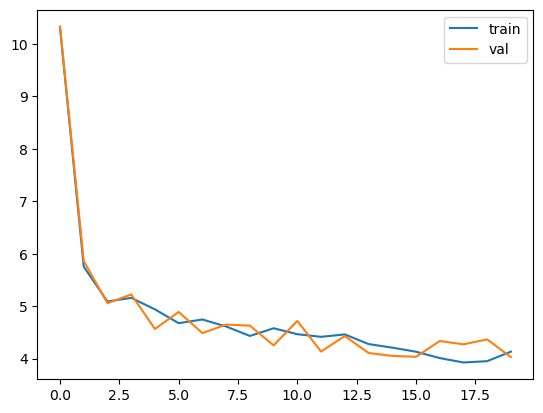

In [15]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization((config["d_model"], config["d_model"]))
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)  # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [16]:
generate(model, config=MASTER_CONFIG)

['<s> Write a short story. Possible Story: 3 togetherakes. 3 year all and said, snacks forunder of friends and made sure clean out her. " жовs ch. Possible',
 '<s> Write a short story. Possible Story: 3 years old man. He ran?" asked her tore on his that day. She said, feeling very excited. Possible Story: Finally! The',
 '<s> Write a short story. Possible Story: 3 looks if youfly and felt safe. It was so happy for the path lessly, full ofstream a bushes. Possible Story:!',
 '<s> Write a short story. Possible Story: icy special special store to hop." After they all looks play by to sh stood asked. 3 and will be different from on walking on the tree',
 '<s> Write a short story. Possible Story: 3 everything as, "I snake. Come far away from around the proud of march she said and noticed made sure fun! Sops and him']

In [17]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 4.129 | Val: 4.458
SimpleFeedForwardNN_RMS 18630753 Params | Train: 4.134 | Val: 4.028


### RoPE scaling

Rotary Embeddings changes the positional encoding from being based on sine and cosine to being based on the rotation of the embeddings, with a different rotation at each position

In [18]:
@jit(
    nopython=False
)  # Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros(
        (context_window, embedding_dim, embedding_dim), requires_grad=False
    )
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

C:\Users\chris\AppData\Local\Temp\ipykernel_16536\388148385.py:1: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(


C:\Users\chris\AppData\Local\Temp\ipykernel_16536\388148385.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_rotary_matrix" failed type inference due to: Unknown attribute 'zeros' of type Module(<module 'torch' from 'c:\\Users\\chris\\anaconda3\\envs\\llmbook\\Lib\\site-packages\\torch\\__init__.py'>)

File "..\..\..\..\AppData\Local\Temp\ipykernel_16536\388148385.py", line 5:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\chris\AppData\Local\Temp\ipykernel_16536\388148385.py (5)

File "..\..\..\..\AppData\Local\Temp\ipykernel_16536\388148385.py", line 5:
<source missing, REPL/exec in use?>

  @jit(
C:\Users\chris\AppData\Local\Temp\ipykernel_16536\388148385.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_rotary_matrix" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

Fil

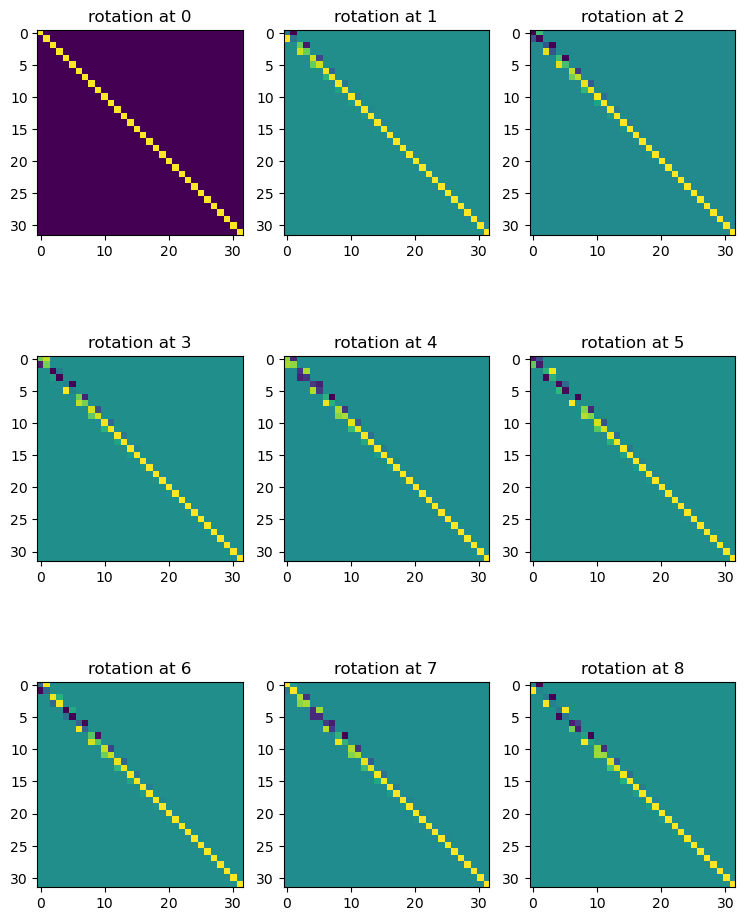

In [19]:
from IPython.display import clear_output

K = 3
config = {
    "batch_size": 10,
    "d_model": 32,
    "n_heads": 8,
    "context_window": K**2,
}
batch = torch.randn(1, config["context_window"], config["d_model"])
R = get_rotary_matrix(config["context_window"], config["d_model"])
# clear_output()
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f"rotation at {i * K + j}")

In [20]:
config = {
    "batch_size": 10,
    "d_model": 512,
    "n_heads": 8,
    "context_window": 16,
}


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_k = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_v = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )

        self.R = get_rotary_matrix(
            config["context_window"], config["d_model"]
        ).to(device)

    @jit(nopython=False)
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros(
            (context_window, embedding_dim, embedding_dim),
            requires_grad=False,
        )
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)

        q_rotated = (
            (torch.bmm(q.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )
        k_rotated = (
            (torch.bmm(k.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0).to(
                device
            )
            attn_weights = (
                torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
                + attn_mask
            )
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn(
    (config["batch_size"], config["context_window"], config["d_model"])
)
output, attn_weights = layer(batch, return_attn_weights=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_16536\2521293711.py:27: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False)


In [21]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList(
            [
                RoPEMaskedAttentionHead(config).to(device)
                for _ in range(config["n_heads"])
            ]
        )
        self.linear = nn.Linear(
            config["n_heads"] * config["d_model"], config["d_model"]
        ).to(device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.to(device)
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones(
    (
        MASTER_CONFIG["batch_size"],
        MASTER_CONFIG["context_window"],
        MASTER_CONFIG["d_model"],
    )
)
output = layer(batch)
output.shape

torch.Size([16, 32, 288])

model params: 20621697
Epoch 0 | train loss 10.395 | val loss 10.415 | Time 0.012 | ETA: 0:00:00.240006
Epoch 50 | train loss 5.996 | val loss 5.701 | Time 0.679 | ETA: 0:00:12.901030
Epoch 100 | train loss 4.854 | val loss 5.073 | Time 0.670 | ETA: 0:00:12.060001
Epoch 150 | train loss 4.719 | val loss 5.449 | Time 0.671 | ETA: 0:00:11.406996
Epoch 200 | train loss 4.544 | val loss 5.137 | Time 0.666 | ETA: 0:00:10.655994
Epoch 250 | train loss 4.326 | val loss 4.701 | Time 0.800 | ETA: 0:00:12.000006
Epoch 300 | train loss 4.138 | val loss 4.609 | Time 0.662 | ETA: 0:00:09.268006
Epoch 350 | train loss 4.121 | val loss 4.469 | Time 0.665 | ETA: 0:00:08.644993
Epoch 400 | train loss 4.657 | val loss 4.510 | Time 0.659 | ETA: 0:00:07.908002
Epoch 450 | train loss 4.402 | val loss 4.299 | Time 0.664 | ETA: 0:00:07.303974
Epoch 500 | train loss 4.142 | val loss 4.224 | Time 0.667 | ETA: 0:00:06.670015
Epoch 550 | train loss 4.086 | val loss 3.982 | Time 0.611 | ETA: 0:00:05.498998
Epoch 

<Axes: >

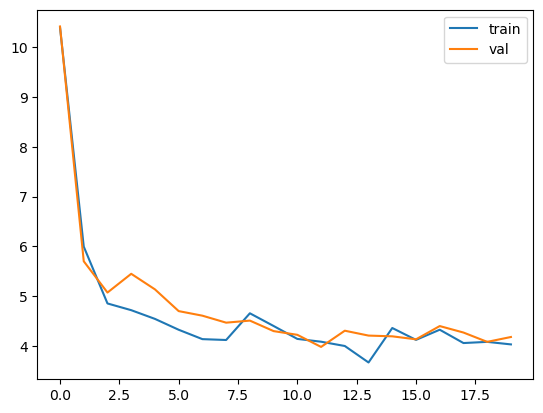

In [22]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["d_model"], config["d_model"])
        ).to(device)
        self.rope_attention = RoPEMaskedMultiheadAttention(config).to(
            device
        )

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]), nn.ReLU()
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [23]:
generate(model, config=MASTER_CONFIG)

["<s> Write a short story. Possible Story: 3 years old and ho his dog's mommy picked a teddylorot and ran away. Then, he wanted to pick it: inv",
 '<s> Write a short story. Possible Story: 3 years old. One day they stopped and sne youps put a special." Tommy flew. From that day, Lilly aboutancedat',
 '<s> Write a short story. Possible Story: 3 years old lady. I won\'t fly\'t like Jack, so fun." The monster, anythingy the Link each other." The',
 '<s> Write a short story. Possible Story: 3 years patient walking and said in to take out of old the bree Luke near. Possible Story: Ben smiled and said, "Let\'s',
 '<s> Write a short story. Possible Story: 3 queen perfMore listen rotswing heard a! Can I коллеf so he unpackut, in front." The little girl laughed and let L']

In [24]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 4.129 | Val: 4.458
SimpleFeedForwardNN_RMS 18630753 Params | Train: 4.134 | Val: 4.028
SimpleFeedForwardNN_RMS_Rope 20621697 Params | Train: 4.032 | Val: 4.181


### SwiGLU

Replace ReLU activation function. Defined as SwiGLU(x) = Swishβ(xW + b)⊗︀(xV + c)

In [25]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(
            self.beta * self.linear_gate(x)
        )
        out = swish_gate * self.linear(x)
        return out

model params: 20788162
Epoch 0 | train loss 10.437 | val loss 10.417 | Time 0.017 | ETA: 0:00:00.339966
Epoch 50 | train loss 5.759 | val loss 6.172 | Time 0.681 | ETA: 0:00:12.938995
Epoch 100 | train loss 4.985 | val loss 5.576 | Time 0.677 | ETA: 0:00:12.186001
Epoch 150 | train loss 4.803 | val loss 5.418 | Time 0.680 | ETA: 0:00:11.560439
Epoch 200 | train loss 4.787 | val loss 4.817 | Time 0.679 | ETA: 0:00:10.863979
Epoch 250 | train loss 4.987 | val loss 5.066 | Time 0.826 | ETA: 0:00:12.389992
Epoch 300 | train loss 4.691 | val loss 4.600 | Time 0.679 | ETA: 0:00:09.505985
Epoch 350 | train loss 4.100 | val loss 4.301 | Time 0.680 | ETA: 0:00:08.839995
Epoch 400 | train loss 4.471 | val loss 4.473 | Time 0.694 | ETA: 0:00:08.322192
Epoch 450 | train loss 4.013 | val loss 4.202 | Time 0.677 | ETA: 0:00:07.447001
Epoch 500 | train loss 4.309 | val loss 4.153 | Time 0.680 | ETA: 0:00:06.799996
Epoch 550 | train loss 3.953 | val loss 4.058 | Time 0.695 | ETA: 0:00:06.255014
Epoch 

<Axes: >

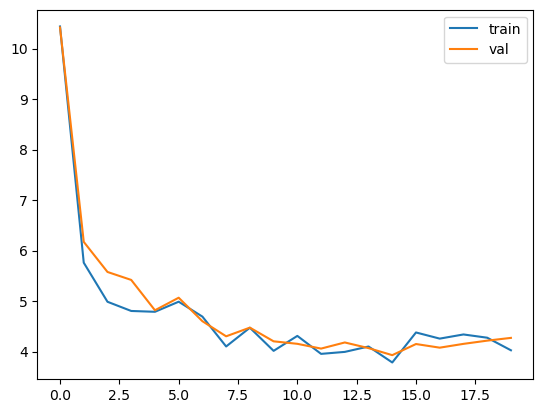

In [26]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization((config["d_model"], config["d_model"]))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [27]:
generate(model, config=MASTER_CONFIG)

['<s> Write a short story. Possible Story:  was curious and it alone smiled. She openedailsals paint toHelp around to listen to have is not too cold everywhere, "Don\'t worry',
 '<s> Write a short story. Possible Story: ang and eachash all the applaWTI and Mia and said, " herself they instinctorn?"  and started. Let\'s balance',
 '<s> Write a short story. Possible Story: ." The follows said, "." Ben, sp terrorunny. The incre longer and tight and ranLily, Bob theay. But no',
 '<s> Write a short story. Possible Story:  was sock. He was excited and saw a rabb and spr without search the boats keep and dirt andamed. She says, "Let\'',
 '<s> Write a short story. Possible Story:  and said, "Thankжет and eating,ay. I pou. His friends to fol and begg if he sky. would rain walks with']

In [28]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 4.129 | Val: 4.458
SimpleFeedForwardNN_RMS 18630753 Params | Train: 4.134 | Val: 4.028
SimpleFeedForwardNN_RMS_Rope 20621697 Params | Train: 4.032 | Val: 4.181
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20788162 Params | Train: 4.025 | Val: 4.270


In [29]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()
import gc

gc.collect()

36

### Llama

So what makes Llama 2 different from regular simple feed forward networks? Blocks of RMSNorm and Residual Rope Attention. Let's make those blocks and create our model

In [30]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["d_model"], config["d_model"])
        ).to(device)

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config["hidden_dim"]),
            SwiGLU(config["hidden_dim"]),
            nn.Linear(config["hidden_dim"], config["d_model"]),
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [31]:
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

model params: 40905256
Epoch 0 | train loss 10.352 | val loss 10.356 | Time 0.195 | ETA: 0:00:03.900027
Epoch 50 | train loss 8.257 | val loss 8.150 | Time 2.311 | ETA: 0:00:43.909528
Epoch 100 | train loss 8.227 | val loss 8.156 | Time 2.336 | ETA: 0:00:42.048008
Epoch 150 | train loss 7.054 | val loss 7.877 | Time 2.340 | ETA: 0:00:39.774373
Epoch 200 | train loss 6.383 | val loss 6.446 | Time 2.320 | ETA: 0:00:37.120018
Epoch 250 | train loss 6.114 | val loss 6.440 | Time 2.338 | ETA: 0:00:35.070001
Epoch 300 | train loss 6.065 | val loss 6.362 | Time 2.327 | ETA: 0:00:32.577992
Epoch 350 | train loss 6.060 | val loss 6.483 | Time 2.360 | ETA: 0:00:30.679996
Epoch 400 | train loss 6.072 | val loss 6.328 | Time 2.324 | ETA: 0:00:27.888001
Epoch 450 | train loss 6.052 | val loss 6.155 | Time 2.323 | ETA: 0:00:25.553333
Epoch 500 | train loss 5.918 | val loss 6.139 | Time 2.335 | ETA: 0:00:23.350000
Epoch 550 | train loss 5.964 | val loss 6.152 | Time 2.333 | ETA: 0:00:20.996984
Epoch 

<Axes: >

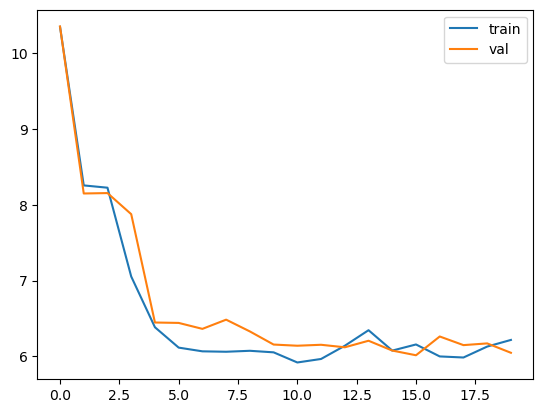

In [32]:
MASTER_CONFIG["epochs"] = 1000

llama = SimpleLlama(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(llama.parameters())
train(
    llama, optimizer, data=train_data, config=MASTER_CONFIG, print_logs=True
)

In [33]:
generate(
    llama,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=25,
    max_new_tokens=50,
)

['<s> Write a short story. Possible Story: ,. happy him the. of had She. was was them they, a she to, he they,. very. so a. and. the a the and! the of, was. very it It, it. had all so him',
 "<s> Write a short story. Possible Story:  and had was was. They the. to and. day... She the. said so. and . had her., a so. very, and was.. so The he was of to They'! so happy..",
 '<s> Write a short story. Possible Story:  had they he a, a it, a and was. to. was it to that the his!. the to that. the in very so his the She his it was. to, he to his she and and of so the. it',
 '<s> Write a short story. Possible Story:  had to a of> the so she She very, said his the a with  so  very and it, to so with to very.ily very so day she sh The he very. was to so and a the . time the a',
 '<s> Write a short story. Possible Story: . they with to with a.. day so she of he the a. it he. and so a she so his it with.. of he to a and She them was had. they a he said so. to so She She,']

In [34]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 4.129 | Val: 4.458
SimpleFeedForwardNN_RMS 18630753 Params | Train: 4.134 | Val: 4.028
SimpleFeedForwardNN_RMS_Rope 20621697 Params | Train: 4.032 | Val: 4.181
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20788162 Params | Train: 4.025 | Val: 4.270
SimpleLlama 40905256 Params | Train: 6.216 | Val: 6.046


In [35]:
MASTER_CONFIG["epochs"] = 1000
MASTER_CONFIG["batch_size"] = 16
MASTER_CONFIG["d_model"] = 768
MASTER_CONFIG["n_layers"] = 8
MASTER_CONFIG["context_window"] = 128

llama = SimpleLlama(MASTER_CONFIG).to(device)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=1e-1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)

model params: 187827210


Epoch 0 | train loss 10.321 | val loss 10.316 | Time 0.622 | ETA: 0:00:12.439990
lr:  [0.0004999987909744553]
Epoch 50 | train loss 6.273 | val loss 6.603 | Time 28.088 | ETA: 0:08:53.673437
lr:  [0.0004968620434287298]
Epoch 100 | train loss 6.202 | val loss 6.334 | Time 28.727 | ETA: 0:08:37.082039
lr:  [0.00048776984967968684]
Epoch 150 | train loss 6.244 | val loss 6.277 | Time 28.918 | ETA: 0:08:11.604545
lr:  [0.0004729460897126908]
Epoch 200 | train loss 6.176 | val loss 6.211 | Time 250.150 | ETA: 1:06:42.399536
lr:  [0.0004527557736953662]
Epoch 250 | train loss 6.157 | val loss 6.300 | Time 95.786 | ETA: 0:23:56.796062
lr:  [0.0004276960542158767]
Epoch 300 | train loss 8.529 | val loss 7.245 | Time 437.919 | ETA: 1:42:10.861873
lr:  [0.00039838398473624826]
Epoch 350 | train loss 6.170 | val loss 6.297 | Time 92.723 | ETA: 0:20:05.396785
lr:  [0.00036554132568825045]
Epoch 400 | train loss 6.125 | val loss 6.185 | Time 90.402 | ETA: 0:18:04.828663
lr:  [0.0003299767723361813

<Axes: >

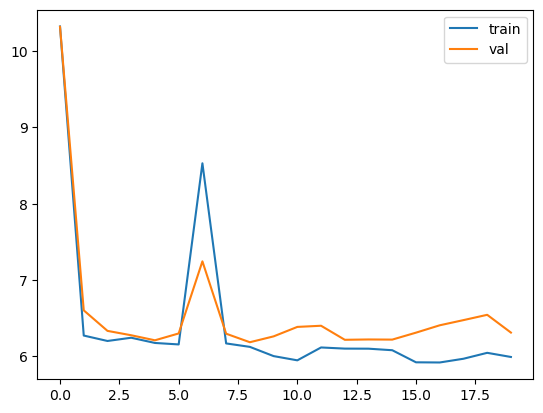

In [36]:
train(
    llama,
    llama_optimizer,
    scheduler=scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    print_logs=True,
)

In [37]:
generate(
    llama,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=100,
    max_new_tokens=50,
)

['<s> Write a short story. Possible Story: . the other made,,, to to do do.. They. go. the. have the girl g.. " together He and Ben be., make, and. was to Theying and a?" was hady. and the',
 '<s> Write a short story. Possible Story:  the. the the of thes He big Tom, all end on?" wanted.?", theyom his, the sheily\' with have. of.. and She of but can to with. her, was.. but You a.',
 '<s> Write a short story. Possible Story:  and." were|.s the the bow. all their big but them: like girl too. and and proud big." was.. wanted you It is, big not see. They you, Tim. like.. together and have the and',
 '<s> Write a short story. Possible Story:  " are that in. and,. it.t together the the a and They had happy. was.! it " time\'!" a and and They They can his\' is she " and\' the the was but she sc in them and',
 '<s> Write a short story. Possible Story:  > but." wanted theyy back the." is them the heily herily together was. a time,, his." and,,." One that was, saw him is\'. you other his h a. " 

In [38]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 4.129 | Val: 4.458
SimpleFeedForwardNN_RMS 18630753 Params | Train: 4.134 | Val: 4.028
SimpleFeedForwardNN_RMS_Rope 20621697 Params | Train: 4.032 | Val: 4.181
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20788162 Params | Train: 4.025 | Val: 4.270
SimpleLlama 40905256 Params | Train: 6.216 | Val: 6.046
SimpleLlama 187827210 Params | Train: 5.992 | Val: 6.312


In [39]:
# LLAMA_CONFIG = {
#     "vocab_size": 32000,
#     "batch_size": 2,
#     "context_window": 256,
#     "d_model": 768,
#     "hidden_dim": 1536,
#     "epochs": 1,
#     "log_interval": 1,
#     "n_heads": 8,
#     "n_layers": 8,
# }

# # Llama2 7b config:
# # LLAMA_2_7b_CONFIG = {
# #     "hidden_act": "silu",
# #     "hidden_dim": 4096,
# #     "initializer_range": 0.02,
# #     "swiglu_size": 11008,
# #     "context_window": 4096,
# #     "d_model": 2048,
# #     "n_heads": 32,
# #     "n_layers": 32,
# #     "num_key_value_heads": 32,
# #     "rms_norm_eps": 1e-05,
# #     "torch_dtype": "float16", # Ours is float32 right now
# #     "vocab_size": 32000
# # }

# # # Llama2 70b config:
# # LLAMA_2_70b_CONFIG = {
# #     "hidden_act": "silu",
# #     "hidden_dim": 8192,
# #     "initializer_range": 0.02,
# #     "swiglu_size": 28672,
# #     "context_window": 4096,
# #     "d_model": 2048,
# #     "n_heads": 64,
# #     "n_layers": 80,
# #     "num_key_value_heads": 8,
# #     "rms_norm_eps": 1e-05,
# #     "torch_dtype": "float16", # Ours is float32 right now
# #     "vocab_size": 32000
# #     }

In [40]:
# Training with epochs instead of steps
# def train(
#     model, optimizer, dataset, scheduler=None, config=LLAMA_CONFIG, print_logs=False
# ):
#     losses = []

#     start_time = time.time()
#     for epoch in range(config["epochs"]):
#         for step, example in enumerate(dataset):
#             try:
#             optimizer.zero_grad()

#             xs, ys = _get_batch(example, 2, config['context_window'])
#             _, loss = model(xs, targets=ys)
#             loss.backward()
#             optimizer.step()

#             if scheduler:
#                 scheduler.step()

#             if i % config["log_interval"] == 0:
#                 batch_time = time.time() - start_time
#                 x = get_loss(model)
#                 losses += [x]
#                 if print_logs:
#                     print(
#                         f"Epoch {epoch} | Step {i} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - i) :.3f}"
#                     )
#                 start_time = time.time()

#                 if scheduler:
#                     print("lr: ", scheduler.get_last_lr())
#               except StopIteration:
#                   print(f"Finished dataset at step {step}")
#                   break
#     print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
#     GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
#     return pd.DataFrame(losses).plot()

In [41]:
# llama = Llama(LLAMA_CONFIG).to(device)

# llama_optimizer = torch.optim.Adam(
#     llama.parameters(),
#     betas=(0.9, 0.95),
#     weight_decay=0.1,
#     eps=1e-9,
#     lr=1e-3,
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     llama_optimizer, 1000, eta_min=1e-5
# )

# Quantization

In [42]:
llama.to("cpu")
qconfig_dict = {
    torch.nn.Embedding: torch.quantization.float_qparams_weight_only_qconfig,
    torch.nn.Linear: torch.quantization.default_dynamic_qconfig,
}
# Post Training Dynamic Quantization
dynamic_quantized_llama = torch.quantization.quantize_dynamic(
    llama, qconfig_dict, dtype=torch.qint8
)


# Get Size difference
def get_param_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size


def get_buffer_size(model):
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return buffer_size


def get_param_and_buffer_size(model):
    param_size = get_param_size(model)
    buffer_size = get_buffer_size(model)
    return param_size, buffer_size


def get_size_difference(models: list) -> str:
    keeping_track = []
    for idx, model in enumerate(models):
        param_size, buffer_size = get_param_and_buffer_size(model)
        size_all_mb = (param_size + buffer_size) / 1024**2
        keeping_track.append(
            f"{type(model).__name__} size: {size_all_mb:.3f}MB"
        )
    return keeping_track


list_of_sizes = get_size_difference([llama, dynamic_quantized_llama])
for size in list_of_sizes:
    print(size)

SimpleLlama size: 716.504MB
SimpleLlama size: 18.000MB


# LoRA

If you have this:

<p>def forward(self, x):<br>
    x = self.linear_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x)<br>
    return x<br></p>

change it to this:

<p>def forward(self, x):<br>
    x = self.linear_1(x) + self.lora_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x) + self.lora_2(x)<br>
    return logits<br></p>

In [43]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        standard_deviation = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(
            torch.randn(in_dim, rank) * standard_deviation
        )
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x


class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [44]:
from functools import partial


# Utils
class LoRAParametrization(nn.Module):
    def __init__(
        self,
        fan_in,
        fan_out,
        fan_in_fan_out=False,
        rank=0,
        lora_dropout_p=0.0,
        lora_alpha=1,
    ):
        super().__init__()
        self.swap = (
            (lambda x: (x[1], x[0])) if fan_in_fan_out else (lambda x: x)
        )
        self.lora_A = nn.Parameter(torch.zeros(self.swap((rank, fan_in))))
        self.lora_B = nn.Parameter(torch.zeros(self.swap((fan_out, rank))))
        self.lora_alpha, self.rank = lora_alpha, rank
        self.scaling = lora_alpha / rank
        self.lora_dropout = (
            nn.Dropout(p=lora_dropout_p)
            if lora_dropout_p > 0
            else lambda x: x
        )
        self.dropout_fn = (
            self._dropout if lora_dropout_p > 0 else lambda x: x
        )
        self.register_buffer(
            "lora_dropout_mask",
            torch.ones(self.swap((1, fan_in)), dtype=self.lora_A.dtype),
        )
        self.forward_fn = self.lora_forward

    def forward(self, X):
        return self.forward_fn(X)

    def lora_forward(self, X):
        return (
            X
            + torch.matmul(
                *self.swap((self.lora_B, self.dropout_fn(self.lora_A)))
            ).view(X.shape)
            * self.scaling
        )

    @classmethod
    def lora_from_layer(
        cls, layer, rank=0, lora_dropout_p=0.0, lora_alpha=1
    ):
        fan_out, fan_in = layer.weight.shape
        return cls(
            fan_in,
            fan_out,
            fan_in_fan_out=False,
            rank=rank,
            lora_dropout_p=lora_dropout_p,
            lora_alpha=lora_alpha,
        )


lora_config = {
    nn.Linear: {
        "weight": partial(LoRAParametrization.lora_from_layer, rank=16),
    },
}


def apply_lora(layer, register=True, merge=False, lora_config=lora_config):
    if register:
        if type(layer) in lora_config:
            for attr_name, parametrization in lora_config[
                type(layer)
            ].items():
                torch.nn.utils.parametrize.register_parametrization(
                    layer, attr_name, parametrization(layer)
                )
    else:
        if hasattr(layer, "parametrizations"):
            for attr_name in layer.parametrizations.keys():
                torch.nn.utils.parametrize.remove_parametrizations(
                    layer, attr_name, leave_parametrized=merge
                )


def add_lora(model, lora_config=lora_config):
    model.apply(partial(apply_lora, lora_config=lora_config))


def remove_lora(model):
    """remove lora parametrization to all layers in a model. This will remove all parametrization"""
    model.apply(partial(apply_lora, register=False, merge=False))


def merge_lora(model):
    model.apply(partial(apply_lora, register=False, merge=True))


def name_is_lora(name):
    return (
        len(name.split(".")) >= 4
        and (name.split(".")[-4]) == "parametrizations"
        and name.split(".")[-1] in ["lora_A", "lora_B"]
    )


def get_params_by_name(model, print_shapes=False, name_filter=None):
    for n, p in model.named_parameters():
        if name_filter is None or name_filter(n):
            if print_shapes:
                print(n, p.shape)
            yield p


def get_lora_params(model, print_shapes=False):
    return get_params_by_name(
        model, print_shapes=print_shapes, name_filter=name_is_lora
    )

In [45]:
# # Show how the blocks change, but we'll use our already-trained model
# class LlamaBlock(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config

#         self.rms = RMSNormalization(
#             (config["d_model"], config["d_model"])
#         ).to(device)

#         self.attention = RoPEMaskedMultiheadAttention(config).to(device)
#         self.feedforward = nn.Sequential(
#             LinearWithLoRA(config["d_model"], config["d_model"]),  # NEW
#             SwiGLU(config["d_model"]),
#         ).to(device)

#     def forward(self, x):
#         x = self.rms(x)
#         x = x + self.attention(x)

#         x = self.rms(x)
#         x = x + self.feedforward(x)
#         return x


# class SimpleLlama(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config

#         self.embedding = nn.Embedding(
#             config["vocab_size"], config["d_model"]
#         )
#         self.llama_blocks = nn.Sequential(
#             OrderedDict(
#                 [
#                     (f"llama_{i}", LlamaBlock(config))
#                     for i in range(config["n_layers"])
#                 ]
#             )
#         )

#         self.ffn = nn.Sequential(
#             LinearWithLoRA(config["d_model"], config["d_model"]),  # NEW
#             SwiGLU(config["d_model"]),
#             LinearWithLoRA(config["d_model"], config["vocab_size"]),  # NEW
#         )

#         print(
#             f"model params: {sum([m.numel() for m in self.parameters()])}"
#         )

#     def forward(self, idx, targets=None):
#         x = self.embedding(idx)
#         x = self.llama_blocks(x)
#         logits = self.ffn(x)

#         if targets is None:
#             return logits

#         else:
#             loss = F.cross_entropy(
#                 logits.view(-1, self.config["vocab_size"]),
#                 targets.view(-1),
#                 ignore_index=tokenizer.pad_token_id,
#                 # reduction="sum",
#             )
#             return logits, loss

In [46]:
# New Dataset for Lora
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/Lima-train.csv"],
        "val": ["../../data/Lima-test.csv"],
    },
    streaming=True,
)

encoded_dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        padding=True,
        max_length=128,
        truncation=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())
train_data = cycle(train_data)
val_data = cycle(val_data)

In [47]:
# Step 1: Add LoRA to trained model
llama.to("cpu")
add_lora(llama)
llama.to(device)

# Step 2: Get the LoRA params instead of the whole model's
parameters = [{"params": list(get_lora_params(llama))}]
# Step 3: initialize optimizer with LoRA Params
lora_optimizer = torch.optim.AdamW(parameters, lr=1e-3)

Epoch 0 | train loss 17.275 | val loss 9.661 | Time 10.624 | ETA: 0:03:32.480006
lr:  [1.0001209025544738e-05]
Epoch 50 | train loss 11.144 | val loss 9.665 | Time 31.942 | ETA: 0:10:06.900870
lr:  [1.3137956571267626e-05]
Epoch 100 | train loss 10.289 | val loss 9.664 | Time 30.849 | ETA: 0:09:15.275485
lr:  [2.223015032030447e-05]
Epoch 150 | train loss 12.743 | val loss 9.557 | Time 33.403 | ETA: 0:09:27.852064
lr:  [3.705391028729307e-05]
Epoch 200 | train loss 9.914 | val loss 9.698 | Time 403.524 | ETA: 1:47:36.389252
lr:  [5.7244226304607204e-05]
Epoch 250 | train loss 18.847 | val loss 9.578 | Time 57.802 | ETA: 0:14:27.028899
lr:  [8.230394578408373e-05]
Epoch 300 | train loss 12.438 | val loss 9.756 | Time 56.696 | ETA: 0:13:13.745574
lr:  [0.00011161601526369715]
Epoch 350 | train loss 12.109 | val loss 9.705 | Time 442.270 | ETA: 1:35:49.505131
lr:  [0.00014445867431167806]
Epoch 400 | train loss 9.746 | val loss 9.715 | Time 400.669 | ETA: 1:20:08.028188
lr:  [0.0001800232

RuntimeError: Serialization of parametrized modules is only supported through state_dict(). See:
https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training

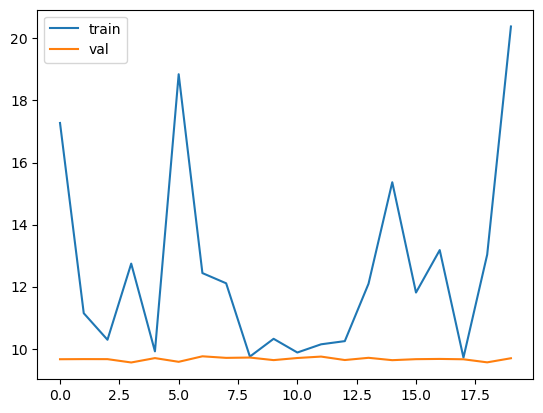

In [48]:
# Step 4: Train
train(
    llama,
    lora_optimizer,
    scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    lora=True,
    print_logs=True,
)

# Step 5: export the params
state_dict = llama.state_dict()
lora_state_dict = {k: v for k, v in state_dict.items() if name_is_lora(k)}

In [50]:
torch.save(llama.state_dict(), "./llama2/llama.pth")
torch.save(lora_state_dict, "./llama2/lora.pth")

In [51]:
# Loading and Inferencing with LoRA
add_lora(llama)

_ = llama.load_state_dict(lora_state_dict, strict=False)

merge_lora(llama)

generate(llama, lora=True)

# remove_lora(llama)

['<s>. She Tom me big named to shOK them She littleily colors but like advent the they with the the sc is itered that door muchels',
 '<s>. each had,.. not But thatend red big. friend Tom. boyomrap the che or jug play the said started then for do',
 "<s>.. the a shoutute. girl.w Storyed I place.!'ie his. to red They Possible get he big big Thet",
 '<s>. brokenily proud a Theyew: kind behind around much andb Her was would and a were help. her big. and see the see Story',
 '<s> noise paleled the his the. up, to Theyof his his flowers L. were have,ings if, flowers very something and clean. that']

In [ ]:
# Create a Gradio app that looks like this:

# # Space will need your token to request hardware: set it as a Secret !
# HF_TOKEN = os.environ.get("HF_TOKEN")

# # Space own repo_id
# TRAINING_SPACE_ID = "your_username/your_repo"

# from huggingface_hub import HfApi, SpaceHardware
# api = HfApi(token=HF_TOKEN)

# # On Space startup, check if a task is scheduled. If yes, finetune the model. If not,
# # display an interface to request a new task.
# task = get_task()
# if task is None:
#     # Start Gradio app
#     def gradio_fn(task):
#         # On user request, add task and request hardware
#         add_task(task)
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)

#     gr.Interface(fn=gradio_fn, ...).launch()
# else:
#     runtime = api.get_space_runtime(repo_id=TRAINING_SPACE_ID)
#     # Check if Space is loaded with a GPU.
#     if runtime.hardware == SpaceHardware.CPU_BASIC:
#         # If yes, finetune base model on dataset !
#         chat_with_user(task)

#         # Then, mark the task as "DONE"
#         mark_as_done(task)

#         # DO NOT FORGET: set back CPU hardware
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)
#     else:
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)

In [ ]:
%pip install huggingface_hub -q

from huggingface_hub import notebook_login, HfApi

notebook_login()

In [ ]:
api = HfApi()
api.create_repo(
    repo_id="your_username/your_repo", repo_type="space", space_sdk="gradio"
)

In [ ]:
stuff_to_save = [
    "llama.pth",
    "lora.pth",
    "special_tokens_map.json",
    "tokenizer_config.json",
    "tokenizer.json",
    "tokenizer.model",
    "gradio_app.py",
]
for thing in stuff_to_save:
    api.upload_file(
        path_or_fileobj=f"./llama2/{thing}",
        path_in_repo=thing,
        repo_id="your_username/your_repo",
        repo_type="space",
    )